# Review Instructions

Please review the MSv4 `field_and_source_xds` schema and the XRADIO interface (`ps['MSv4_name'].VISIBILITY.field_and_source_xds`). Note that the PS (processing set) interface or the main_xds should not be reviewed.

The `field_and_source_xds` schema specification: https://docs.google.com/spreadsheets/d/14a6qMap9M5r_vjpLnaBKxsR9TF4azN5LVdOxLacOX-s/edit#gid=1658760192

## Preparatory Material
Go over Xarray nomenclature and selection syntax:
- https://docs.xarray.dev/en/latest/user-guide/terminology.html
- https://docs.xarray.dev/en/latest/user-guide/indexing.html

MSv2 and CASA documentation:
- MSv2 schema: https://casacore.github.io/casacore-notes/229.pdf
- MSv3 schema: https://casacore.github.io/casacore-notes/264.pdf
- Ephemeris Data in CASA: https://casadocs.readthedocs.io/en/latest/notebooks/external-data.html#Ephemeris-Data

## `field_and_source_xds` Schema
The FIELD, SOURCE, and EPHEMERIS tables in the MSv2 contain closely related information:
- **FIELD**: Field position for a source.
- **SOURCE**: Information about the source being observed (position, proper motion, etc.)
- **EPHEMERIS**: Ephemerides of the source.

These can be combined into a single dataset for MSv4 because it consists of a single field and consequently a single source[^1].

### Use Cases
The use cases considered during the design of the schema were:
- Single field observation (type=standard).
- Mosaic observation (type=standard).
- Ephemeris observation (type=ephemeris).
- Mosaic Ephemeris observation (type=ephemeris).

To satisfy these use cases, two types of `field_and_source_xds` were created: standard and ephemeris. The main difference is that the ephemeris type has a `FIELD_PHASE_OFFSET` data variable that is relative to the `SOURCE_POSITION/SOURCE_DIRECTION` data variable (contains the ephemerides and has a time axis), while the standard type has `FIELD_PHASE/DELAY/REFERENCE_CENTERS` and `SOURCE_POSITION` (has no time axis). The `SOURCE_POSITION/DIRECTION` is kept separate from the `FIELD_PHASE_OFFSET/CENTER` so that the intent `OBSERVE_TARGET#OFF_SOURCE` is supported and the ephemeris can be easily changed.

## Key Questions to Answer
### Schema Questions
- 1.1) Are there missing use cases?
- 1.2) Is all the information present needed for offline processing?
  - 1.2.1) Are there data variables we need to add (for example, the JPL Horizons data has additional information such as the North pole position angle, etc., see [CASA Ephemeris Data](https://casadocs.readthedocs.io/en/latest/notebooks/external-data.html#Ephemeris-Data))?
  - 1.2.2) In some CASA ephemeris tables, there are table keywords such as `VS_CREATE`, `VS_DATE`, `VS_TYPE`, `VS_VERSION`, `MJD0`, `dMJD`, `earliest`, `latest`, `radii`, `meanradm`, `orb_per`, `rot_per`. Do we need any of these?
- 1.3) Is there a use case where the `FIELD_PHASE_CENTER` and `FIELD_DELAY_CENTER` would differ (i.e., do we need to store both)?
- 1.4) For interferometer observations, do we need to store the `FIELD_REFERENCE_CENTER` or can this be omitted (will still be present for Single dish)?
- 1.5) The ephemeris data is recorded in degrees, AU, and MJD. Should these be converted to radians, meters, and time (Unix)? Note that each data variable has measurement information attached to it. For example:
```Python
  frame: ICRS
  type: sky_coord
  units: ['deg', 'deg', 'AU']
```

- 1.6) For ephemeris observations, should we add the SOURCE_PROPER_MOTION if available?
- 1.7) Is the name `field_and_source_xds` sufficiently descriptive?
- 1.8) Should we also add the DOPPLER table information to the schema (if so, any idea where we can get an MSv2 with a DOPPLER table)?
- 1.9) Any naming suggestions or data layout?
- 1.10) Are the data variable descriptions in the schema spreadsheet correct?
- 1.11) What measures (https://docs.google.com/spreadsheets/d/14a6qMap9M5r_vjpLnaBKxsR9TF4azN5LVdOxLacOX-s/edit#gid=1504318014) should we attach to each of the following data variables

  - NORTH_POLE_POSITION_ANGLE (quantity?)
  - NORTH_POLE_ANGULAR_DISTANCE (quantity?)
  - SUB_OBSERVER_DIRECTION (earth_location?)
  - SUB_SOLAR_POSITION (earth_location?)
  - HELIOCENTRIC_RADIAL_VELOCITY (quantity?)
  - OBSERVER_PHASE_ANGLE (quantity?)
- 1.12) Can NORTH_POLE_POSITION_ANGLE and NORTH_POLE_ANGULAR_DISTANCE be combined into a single data variable?

### XRADIO
2.1) After reviewing the XARRAY documentation and the descriptions of the data variables in the `field_and_source_xds` schema, do you find the XARRAY interface intuitive and easy to use?



[^1]: This is inhereted from MSv2 that only allows a single source per field [https://casacore.github.io/casacore-notes/229.pdf, p35], though a source can appear in more than one field.


# Environment instructions

It is recommended to use the conda environment manager to create a clean, self-contained runtime where xradio and all its dependencies can be installed:

```bash
conda create --name xradio python=3.11 --no-default-packages
conda activate xradio
```

Clone the repository, checkout the review branch and do a local install:

```bash
git clone https://github.com/casangi/xradio.git
git checkout 162-create-combined-field-source-and-ephemeris-dataset
cd xradio
pip install -e .
```

# ALMA Example

An ephemeris mosaic observation of the sun.

ALMA archive file downloaded: https://almascience.nrao.edu/dataPortal/2022.A.00001.S_uid___A002_X1003af4_X75a3.asdm.sdm.tar 

- Project: 2022.A.00001.S
- Member ous id (MOUS): uid://A001/X3571/X130
- Group ous id (GOUS): uid://A001/X3571/X131

CASA commands used to create the dataset:
```python
importasdm(asdm='uid___A002_X1003af4_X75a3.asdm.sdm',vis='uid___A002_X1003af4_X75a3.ms',asis='Ephemeris Antenna Station Receiver Source CalAtmosphere CalWVR',bdfflags=True,with_pointing_correction=True,convert_ephem2geo=True)

importasdm(asdm='22A-347.sb41163051.eb41573599.59642.62832791667.asdm',vis='22A-347.sb41163051.eb41573599.59642.62832791667.ms',asis='Ephemeris Antenna Station Receiver Source',with_pointing_correction=True,convert_ephem2geo=True)

mstransform(vis='ALMA_uid___A002_X1003af4_X75a3.split.ms',outputvis='ALMA_uid___A002_X1003af4_X75a3.split.avg.ms',createmms=False,timeaverage=True,timebin='2s',timespan='scan',reindex=True)

import numpy as np
for subtable in ['FLAG_CMD', 'POINTING', 'CALDEVICE', 'ASDM_CALATMOSPHERE']:
    tb.open('ALMA_uid___A002_X1003af4_X75a3.split.avg.ms::'+subtable,nomodify=False)
    tb.removerows(np.arange(tb.nrows())) 
    tb.flush()
    tb.done()
```


## Download Data

In [1]:
from xradio.vis.convert_msv2_to_processing_set import convert_msv2_to_processing_set
from xradio.vis.read_processing_set import read_processing_set
import graphviper

toolviper.utils.data.download(file="ALMA_uid___A002_X1003af4_X75a3.split.avg.ms")

[2024-08-05 18:33:44,256]  WARNING  graphviper:  File exists: /Users/jsteeb/Dropbox/graphviper/src/graphviper/utils/data/.dropbox 
[2024-08-05 18:33:44,260]     INFO  graphviper:  Updating file metadata information ...  
 

 Download List                                
 ───────────────────────────────────────────── 
  ALMA_uid___A002_X1003af4_X75a3.split.avg.ms

[2024-08-05 18:33:44,943]     INFO  graphviper:  File exists: ALMA_uid___A002_X1003af4_X75a3.split.avg.ms 


# Start Dask cluster 
Choose an approriate number of cores and memory_limit (this is per core).

In [2]:
from toolviper.dask.client import local_client

viper_client = local_client(cores=4, memory_limit="4GB")
viper_client

[2024-08-05 18:33:45,056]     INFO  graphviper:  Checking parameter values for client.local_client 
[2024-08-05 18:33:45,056]     INFO  graphviper:  Module path: /Users/jsteeb/Dropbox/graphviper/ 
[2024-08-05 18:33:45,060]  WARNING      client:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 


/Users/jsteeb/Downloads/yes/envs/zinc/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62705 instead
  warnings.warn(


[2024-08-05 18:33:45,740]     INFO      client:  Created client <MenrvaClient: 'tcp://127.0.0.1:62706' processes=4 threads=4, memory=14.90 GiB> 


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:62705/status,
Dashboard: http://127.0.0.1:62705/status,Workers: 4
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62706,Workers: 4
Dashboard: http://127.0.0.1:62705/status,Total threads: 4
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:62717,Total threads: 1
Dashboard: http://127.0.0.1:62719/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:62709,


# Convert dataset

In [1]:
from xradio.correlated_data.convert_msv2_to_processing_set import convert_msv2_to_processing_set
import os

in_file = "ALMA_uid___A002_X1003af4_X75a3.split.avg.ms"

out_file = "ALMA_uid___A002_X1003af4_X75a3.split.avg.zarr"
partition_scheme=[] #must be ephemeris_interpolate=True

#out_file = "ALMA_uid___A002_X1003af4_X75a3.split.avg.fid.zarr"
#partition_scheme=['FIELD_ID'] #can be ephemeris_interpolate=True/False

os.system("rm -rf "+out_file)

convert_msv2_to_processing_set(
    in_file=in_file,
    out_file=out_file,
    parallel=False,
    overwrite=True,
    ephemeris_interpolate=True,
    partition_scheme=partition_scheme
)



[2024-09-26 17:56:53,496]     INFO   toolviper:  Partition scheme that will be used: ['DATA_DESC_ID', 'OBS_MODE', 'OBSERVATION_ID'] 
[2024-09-26 17:56:53,524]     INFO   toolviper:  Number of partitions: 18 
[2024-09-26 17:56:53,525]     INFO   toolviper:  OBSERVATION_ID [0], DDI [0], STATE [0], FIELD [0], SCAN [7] 
[2024-09-26 17:56:53,804]     INFO   toolviper:  OBSERVATION_ID [0], DDI [0], STATE [16], FIELD [0], SCAN [7] 
[2024-09-26 17:56:53,943]     INFO   toolviper:  OBSERVATION_ID [0], DDI [0], STATE [17], FIELD [0], SCAN [7] 
[2024-09-26 17:56:54,082]     INFO   toolviper:  OBSERVATION_ID [0], DDI [0], STATE [19], FIELD [2], SCAN [6] 
[2024-09-26 17:56:54,188]     INFO   toolviper:  OBSERVATION_ID [0], DDI [0], STATE [20 99], FIELD [0], SCAN [8] 
[2024-09-26 17:56:54,321]     INFO   toolviper:  OBSERVATION_ID [0], DDI [0], STATE [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 7

# Inspect Processing Set

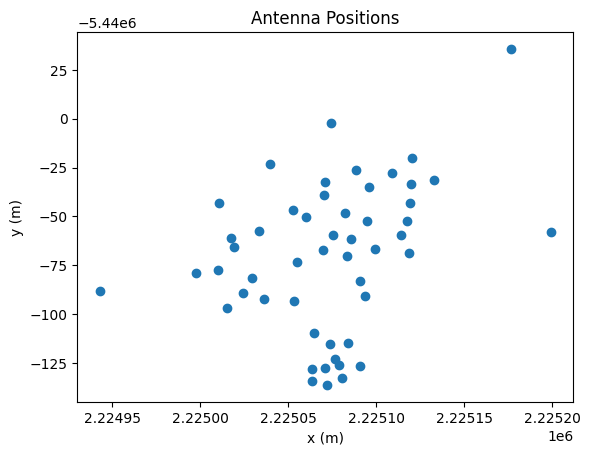

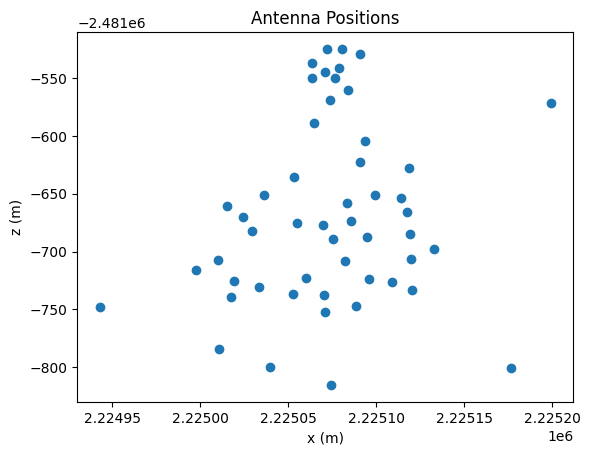

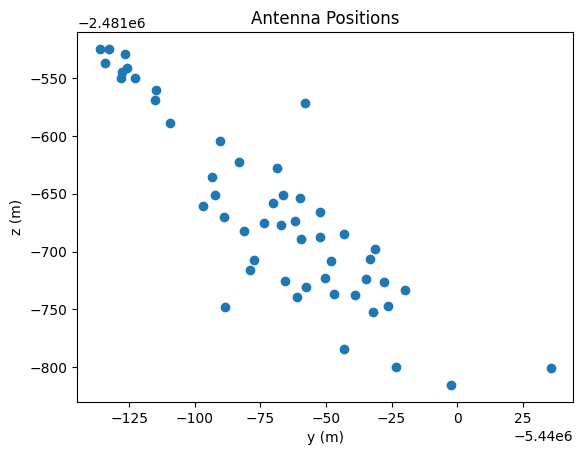

<xarray.Dataset> Size: 8kB
Dimensions:                 (antenna_name: 51, cartesian_pos_label: 3,
                             receptor_label: 2, sky_dir_label: 2)
Coordinates:
  * antenna_name            (antenna_name) <U9 2kB 'CM01_N602' ... 'DV25_A011'
  * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
    mount                   (antenna_name) <U6 1kB dask.array<chunksize=(51,), meta=np.ndarray>
    polarization_type       (antenna_name, receptor_label) <U1 408B dask.array<chunksize=(51, 2), meta=np.ndarray>
  * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
    station                 (antenna_name) <U4 816B dask.array<chunksize=(51,), meta=np.ndarray>
    telescope_name          (antenna_name) <U4 816B dask.array<chunksize=(51,), meta=np.ndarray>
  * sky_dir_label           (sky_dir_label) <U3 24B 'ra' 'dec'
Data variables:
    ANTENNA_DISH_DIAMETER   (antenna_name) float64 408B dask.array<chunksize=(51,), meta=np.ndarray>
    ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 1kB dask.array<chunksize=(51, 3), meta=np.ndarray>
    ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 816B dask.array<chunksize=(51, 2), meta=np.ndarray>
Attributes:
    overall_telescope_name:  ALMA
    relocatable_antennas:    True
    type:                    antenna

In [1]:
import pandas as pd

# Set the maximum number of rows displayed before scrolling
pd.set_option("display.max_rows", 1000)

from xradio.correlated_data.open_processing_set import open_processing_set

#ps = open_processing_set("ALMA_uid___A002_X1003af4_X75a3.split.avg.fid.zarr")
ps = open_processing_set("ALMA_uid___A002_X1003af4_X75a3.split.avg.zarr")
#ps.plot_phase_centers()
# combined_field_and_source_xds, combined_ephemeris_field_and_source_xds = ps.get_combined_field_and_source_xds()
# # combined_ephemeris_field_and_source_xds
# # combined_field_and_source_xds
# ps.plot_phase_centers()
# combined_ephemeris_field_and_source_xds

ant_xds = ps.get_combined_antenna_xds()
ps.plot_antenna_positions()
ant_xds

In [3]:
ant_xds.ANTENNA_RECEPTOR_ANGLE.values

array([[-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449, -0.78539816],
       [-2.35619449,

In [3]:
ant_xds.polarization_type.values

array([['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X'],
       ['X', 'X']], dtype='<U1')

In [6]:
set(ps.get(0).attrs['data_groups']['base'].values())

ps.get(0).attrs['data_groups']

xds= ps.get(0)
xds["VISIBILITY_CORRECTED"] = xds["VISIBILITY"]

xds.attrs['data_groups']['corrected'] = {'correlated_data': 'VISIBILITY_CORRECTED',
  'flag': 'FLAG',
  'uvw': 'UVW',
  'weight': 'WEIGHT'}

xds.sel(data_group_name='corrected')

<xarray.CorrelatedXds> Size: 14kB
Dimensions:                     (baseline_id: 51, time: 2, frequency: 4,
                                 polarization: 1, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB dask.array<chunksize=(51,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 2kB dask.array<chunksize=(51,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 408B 0 1 2 3 ... 47 48 49 50
    scan_number                 (time) int64 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * time                        (time) float64 16B 1.667e+09 1.667e+09
  * frequency                   (frequency) float64 32B 1.846e+11 ... 1.906e+11
  * polarization                (polarization) <U2 8B 'XX'
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 816B dask.array<chunksize=(2, 51), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 408B dask.array<chunksize=(2, 51, 4, 1), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 816B dask.array<chunksize=(2, 51), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 2kB dask.array<chunksize=(2, 51, 3), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 2kB dask.array<chunksize=(2, 51, 4, 1), meta=np.ndarray>
    VISIBILITY_CORRECTED        (time, baseline_id, frequency, polarization) complex64 3kB dask.array<chunksize=(2, 51, 4, 1), meta=np.ndarray>
Attributes:
    creation_date:     2024-09-26T21:56:54.838583
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'flag': 'FL...
    observation_info:  {'observer': ['kreardon'], 'project': 'uid://A001/X335...
    partition_info:    {'field_name': ['Sun_10_0'], 'intents': ['CALIBRATE_AT...
    processor_info:    {'sub_type': 'ALMA_RADIOMETER', 'type': 'RADIOMETER'}
    schema_version:    4.0.-9997
    type:              visibility
    xradio_version:    0.0.41
    antenna_xds:       <xarray.Dataset> Size: 7kB\nDimensions:               ...

In [21]:
a= {'FLAG', 'UVW', 'VISIBILITY', 'WEIGHT'}
b= {'FLAG', 'UVW', 'VISIBILITY_CORRECTED', 'WEIGHT'}
b-a

dgs= ps.get(0).attrs['data_groups']
dgs['corrected']={'correlated_data': 'VISIBILITY_CORRECTED',
  'flag': 'FLAG',
  'uvw': 'UVW',
  'weight': 'WEIGHT'}

sel_data_group_set = set(dgs['base'].values())
            
data_variables_to_drop = []
for dg in dgs.values():
    temp_set = set(dg.values()) - sel_data_group_set
    data_variables_to_drop.extend(list(temp_set))
data_variables_to_drop = set(data_variables_to_drop)


data_variables_to_drop

{'VISIBILITY_CORRECTED'}

In [8]:
ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
18,ALMA_uid___A002_X1003af4_X75a3.split.avg_00,"[CALIBRATE_ATMOSPHERE#OFF_SOURCE, CALIBRATE_WV...","(3, 51, 1, 2)","[XX, YY]",[7],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_0],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
8,ALMA_uid___A002_X1003af4_X75a3.split.avg_01,"[CALIBRATE_ATMOSPHERE#AMBIENT, CALIBRATE_WVR#A...","(3, 51, 1, 2)","[XX, YY]",[7],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_0],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
49,ALMA_uid___A002_X1003af4_X75a3.split.avg_02,"[CALIBRATE_ATMOSPHERE#HOT, CALIBRATE_WVR#HOT]","(3, 51, 1, 2)","[XX, YY]",[7],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_0],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
58,ALMA_uid___A002_X1003af4_X75a3.split.avg_03,"[CALIBRATE_PHASE#ON_SOURCE, CALIBRATE_WVR#ON_S...","(31, 51, 1, 2)","[XX, YY]",[6],X767114449#ALMA_RB_06#BB_4#SQLD_0,[J1408-0752_2],[J1408-0752_2],[],"[icrs, 14h08m56.48s, -7d52m26.67s]",2.480000e+11,2.480000e+11
59,ALMA_uid___A002_X1003af4_X75a3.split.avg_04,[OBSERVE_TARGET#OFF_SOURCE],"(14, 51, 1, 2)","[XX, YY]",[8],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_0],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
48,ALMA_uid___A002_X1003af4_X75a3.split.avg_05,[OBSERVE_TARGET#ON_SOURCE],"(12, 51, 1, 2)","[XX, YY]",[8],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_3],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
10,ALMA_uid___A002_X1003af4_X75a3.split.avg_06,[OBSERVE_TARGET#ON_SOURCE],"(12, 51, 1, 2)","[XX, YY]",[8],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_4],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
17,ALMA_uid___A002_X1003af4_X75a3.split.avg_07,[OBSERVE_TARGET#ON_SOURCE],"(12, 51, 1, 2)","[XX, YY]",[8],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_5],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
6,ALMA_uid___A002_X1003af4_X75a3.split.avg_08,[OBSERVE_TARGET#ON_SOURCE],"(12, 51, 1, 2)","[XX, YY]",[8],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_6],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11
19,ALMA_uid___A002_X1003af4_X75a3.split.avg_09,[OBSERVE_TARGET#ON_SOURCE],"(12, 51, 1, 2)","[XX, YY]",[8],X767114449#ALMA_RB_06#BB_4#SQLD_0,[Sun_10_7],[Sun_10_0],[],Ephemeris,2.480000e+11,2.480000e+11


In [9]:
import numpy as np
def wrap_to_pi(angles):
    return (angles + np.pi) % (2 * np.pi) - np.pi

def wrap_to_pi_2(angles):
    while np.any(angles > np.pi / 2) or np.any(angles < -np.pi / 2):
        angles = np.where(
            angles > np.pi / 2, angles - np.pi, angles
        )
        angles = np.where(
            angles < -np.pi / 2, angles + np.pi, angles
        )
    return angles

a = np.array([[7.8, 6.2, -100.0, 3.5],[7.8, 6.2, -1.0, 3.5]])
wrap_to_pi(a) #array([ 1.51681469, -0.08318531,  0.53096491, -2.78318531])
wrap_to_pi_2(a)

array([[ 1.51681469, -0.08318531,  0.53096491,  0.35840735],
       [ 1.51681469, -0.08318531, -1.        ,  0.35840735]])

In [4]:
2*np.pi

6.283185307179586

In [5]:
if len(partition_scheme)==0: #Largest partitions, 
    msv4_name_ephemeris = "ALMA_uid___A002_X1003af4_X75a3.split.avg_17"
    msv4_name = "ALMA_uid___A002_X1003af4_X75a3.split.avg_15"
else: #Partition also by Field_id (default behavior).
    msv4_name_ephemeris = "ALMA_uid___A002_X1003af4_X75a3.split.avg_81"
    msv4_name = "ALMA_uid___A002_X1003af4_X75a3.split.avg_67"
    
msv4_name

'ALMA_uid___A002_X1003af4_X75a3.split.avg_15'

In [6]:
ps[msv4_name].partition_info

{'field_name': ['J1408-0752_2'],
 'num_lines': 1,
 'obs_mode': 'CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE',
 'polarization_setup': ['XX', 'YY'],
 'source_name': ['J1408-0752_2'],
 'spectral_window_name': 'X767114449#ALMA_RB_06#BB_1#SW-01#FULL_RES_2',
 'taql': 'WHERE (DATA_DESC_ID IN [2]) AND(OBSERVATION_ID IN [0]) AND(STATE_ID IN [19]) AND(FIELD_ID IN [2]) AND(SCAN_NUMBER IN [6]) AND(STATE_ID IN [19]) '}

In [7]:
ps[msv4_name]

<xarray.Dataset> Size: 9MB
Dimensions:                     (time: 30, baseline_id: 1326, frequency: 7,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 48kB dask.array<chunksize=(1326,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 48kB dask.array<chunksize=(1326,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 11kB 0 1 2 ... 1324 1325
  * frequency                   (frequency) float64 56B 2.3e+11 ... 2.301e+11
  * polarization                (polarization) <U2 16B 'XX' 'YY'
  * time                        (time) float64 240B 1.667e+09 ... 1.667e+09
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 318kB dask.array<chunksize=(30, 1326), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 557kB dask.array<chunksize=(30, 1326, 7, 2), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 318kB dask.array<chunksize=(30, 1326), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 955kB dask.array<chunksize=(30, 1326, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 4MB dask.array<chunksize=(30, 1326, 7, 2), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 2MB dask.array<chunksize=(30, 1326, 7, 2), meta=np.ndarray>
Attributes:
    data_groups:     {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'V...
    partition_info:  {'field_name': ['J1408-0752_2'], 'num_lines': 1, 'obs_mo...
    pointing_xds:    <xarray.Dataset> Size: 0B\nDimensions:  ()\nData variabl...
    weather_xds:     <xarray.Dataset> Size: 138kB\nDimensions:         (stati...
    antenna_xds:     <xarray.Dataset> Size: 6kB\nDimensions:                (...

# Inspect field_and_source_xds: Standard Use case (non-ephemeris)

In [8]:
standard_field_and_source_xds = ps[
    msv4_name
].VISIBILITY.field_and_source_xds.load()  # Load the data into memory
standard_field_and_source_xds

<xarray.Dataset> Size: 256B
Dimensions:                 (sky_dir_label: 2, line_label: 1)
Coordinates:
    field_name              <U12 48B 'J1408-0752_2'
    line_name               (line_label) <U22 88B 'Single_Continuum(ID=0)'
  * sky_dir_label           (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name             <U12 48B 'J1408-0752_2'
Dimensions without coordinates: line_label
Data variables:
    FIELD_PHASE_CENTER      (sky_dir_label) float64 16B -2.579 -0.1374
    LINE_REST_FREQUENCY     (line_label) float64 8B 2.3e+11
    LINE_SYSTEMIC_VELOCITY  (line_label) float64 8B 0.0
    SOURCE_DIRECTION        (sky_dir_label) float64 16B -2.579 -0.1374
Attributes:
    is_ephemeris:  False

In [9]:
standard_field_and_source_xds  # How to access field_and_source_xds.

<xarray.Dataset> Size: 256B
Dimensions:                 (sky_dir_label: 2, line_label: 1)
Coordinates:
    field_name              <U12 48B 'J1408-0752_2'
    line_name               (line_label) <U22 88B 'Single_Continuum(ID=0)'
  * sky_dir_label           (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name             <U12 48B 'J1408-0752_2'
Dimensions without coordinates: line_label
Data variables:
    FIELD_PHASE_CENTER      (sky_dir_label) float64 16B -2.579 -0.1374
    LINE_REST_FREQUENCY     (line_label) float64 8B 2.3e+11
    LINE_SYSTEMIC_VELOCITY  (line_label) float64 8B 0.0
    SOURCE_DIRECTION        (sky_dir_label) float64 16B -2.579 -0.1374
Attributes:
    is_ephemeris:  False

In [10]:
standard_field_and_source_xds.FIELD_PHASE_CENTER  # How to access field_and_source_xds datavariables. standard_field_and_source_xds['FIELD_PHASE_CENTER'] can also be used.

<xarray.DataArray 'FIELD_PHASE_CENTER' (sky_dir_label: 2)> Size: 16B
array([-2.57897986, -0.13742852])
Coordinates:
    field_name     <U12 48B 'J1408-0752_2'
  * sky_dir_label  (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name    <U12 48B 'J1408-0752_2'
Attributes:
    frame:    ICRS
    type:     sky_coord
    units:    ['rad', 'rad']

In [11]:
standard_field_and_source_xds.FIELD_PHASE_CENTER.attrs  # How to access field_and_source_xds datavariables measures information stored in the attributes.

{'frame': 'ICRS', 'type': 'sky_coord', 'units': ['rad', 'rad']}

# Inspect field_and_source_xds: Ephemeris Use case (Mosaic) with line

In [12]:
ephemeris_field_and_source_xds = ps[
    msv4_name_ephemeris
].VISIBILITY.field_and_source_xds.load()  # Load the data into memory
ephemeris_field_and_source_xds

<xarray.Dataset> Size: 105kB
Dimensions:                       (time: 234, sky_pos_label: 3, line_label: 1,
                                   ellipsoid_pos_label: 3, sky_dir_label: 2)
Coordinates:
  * ellipsoid_pos_label           (ellipsoid_pos_label) <U4 48B 'lon' ... 'dist'
    field_name                    (time) <U28 26kB 'Sun_10_3' ... 'Sun_10_26'
    line_name                     (time, line_label) <U22 21kB 'Single_Contin...
  * sky_dir_label                 (sky_dir_label) <U3 24B 'ra' 'dec'
  * sky_pos_label                 (sky_pos_label) <U4 48B 'ra' 'dec' 'dist'
    source_name                   (time) <U28 26kB 'Sun_10_0' ... 'Sun_10_0'
  * time                          (time) float64 2kB 1.667e+09 ... 1.667e+09
Dimensions without coordinates: line_label
Data variables:
    FIELD_PHASE_CENTER            (time, sky_pos_label) float64 6kB -2.624 .....
    HELIOCENTRIC_RADIAL_VELOCITY  (time) float64 2kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LINE_REST_FREQUENCY           (time, line_label) float64 2kB 2.3e+11 ... ...
    LINE_SYSTEMIC_VELOCITY        (time, line_label) float64 2kB 0.0 0.0 ... 0.0
    NORTH_POLE_ANGULAR_DISTANCE   (time) float64 2kB 542.7 542.7 ... 549.5 549.6
    NORTH_POLE_POSITION_ANGLE     (time) float64 2kB 14.5 14.5 ... 14.68 14.68
    OBSERVATION_POSITION          (ellipsoid_pos_label) float64 24B 0.0 0.0 0.0
    OBSERVER_PHASE_ANGLE          (time) float64 2kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SOURCE_POSITION               (time, sky_pos_label) float64 6kB 3.659 ......
    SOURCE_RADIAL_VELOCITY        (time) float64 2kB -205.3 -205.3 ... -202.0
    SUB_OBSERVER_POSITION         (time, ellipsoid_pos_label) float64 6kB 3.0...
Attributes:
    is_ephemeris:  True

In [13]:
ephemeris_field_and_source_xds.FIELD_PHASE_CENTER

<xarray.DataArray 'FIELD_PHASE_CENTER' (time: 234, sky_pos_label: 3)> Size: 6kB
array([[-2.62435062e+00, -2.11302878e-01,  1.48765976e+11],
       [-2.62435023e+00, -2.11303019e-01,  1.48765975e+11],
       [-2.62434984e+00, -2.11303159e-01,  1.48765974e+11],
       [-2.62429093e+00, -2.11303430e-01,  1.48765972e+11],
       [-2.62429054e+00, -2.11303570e-01,  1.48765971e+11],
       [-2.62429015e+00, -2.11303711e-01,  1.48765970e+11],
       [-2.62423124e+00, -2.11303982e-01,  1.48765968e+11],
       [-2.62423085e+00, -2.11304122e-01,  1.48765967e+11],
       [-2.62423046e+00, -2.11304263e-01,  1.48765966e+11],
       [-2.62417155e+00, -2.11304533e-01,  1.48765965e+11],
       [-2.62417116e+00, -2.11304674e-01,  1.48765964e+11],
       [-2.62417077e+00, -2.11304814e-01,  1.48765963e+11],
       [-2.62437358e+00, -2.11254717e-01,  1.48765961e+11],
       [-2.62437319e+00, -2.11254857e-01,  1.48765960e+11],
       [-2.62437280e+00, -2.11254998e-01,  1.48765959e+11],
       [-2.62431389e+00, -2.11255269e-01,  1.48765957e+11],
       [-2.62431350e+00, -2.11255409e-01,  1.48765956e+11],
       [-2.62431311e+00, -2.11255550e-01,  1.48765955e+11],
       [-2.62425420e+00, -2.11255820e-01,  1.48765953e+11],
       [-2.62425381e+00, -2.11255961e-01,  1.48765953e+11],
...
       [-2.62403801e+00, -2.11191088e-01,  1.48765710e+11],
       [-2.62403762e+00, -2.11191228e-01,  1.48765709e+11],
       [-2.62424043e+00, -2.11141131e-01,  1.48765707e+11],
       [-2.62424004e+00, -2.11141271e-01,  1.48765706e+11],
       [-2.62423965e+00, -2.11141412e-01,  1.48765705e+11],
       [-2.62418074e+00, -2.11141683e-01,  1.48765703e+11],
       [-2.62418035e+00, -2.11141823e-01,  1.48765702e+11],
       [-2.62417996e+00, -2.11141964e-01,  1.48765701e+11],
       [-2.62412105e+00, -2.11142234e-01,  1.48765700e+11],
       [-2.62412066e+00, -2.11142375e-01,  1.48765699e+11],
       [-2.62412027e+00, -2.11142515e-01,  1.48765698e+11],
       [-2.62406136e+00, -2.11142786e-01,  1.48765696e+11],
       [-2.62406097e+00, -2.11142927e-01,  1.48765695e+11],
       [-2.62406058e+00, -2.11143067e-01,  1.48765694e+11],
       [-2.62426339e+00, -2.11092970e-01,  1.48765692e+11],
       [-2.62426300e+00, -2.11093110e-01,  1.48765691e+11],
       [-2.62426261e+00, -2.11093251e-01,  1.48765690e+11],
       [-2.62420370e+00, -2.11093521e-01,  1.48765688e+11],
       [-2.62420331e+00, -2.11093662e-01,  1.48765687e+11],
       [-2.62420292e+00, -2.11093802e-01,  1.48765687e+11]])
Coordinates:
    field_name     (time) <U28 26kB 'Sun_10_3' 'Sun_10_3' ... 'Sun_10_26'
  * sky_pos_label  (sky_pos_label) <U4 48B 'ra' 'dec' 'dist'
    source_name    (time) <U28 26kB 'Sun_10_0' 'Sun_10_0' ... 'Sun_10_0'
  * time           (time) float64 2kB 1.667e+09 1.667e+09 ... 1.667e+09
Attributes:
    frame:    ICRS
    type:     sky_coord
    units:    ['rad', 'rad', 'm']

In [14]:
ephemeris_field_and_source_xds.SOURCE_POSITION

<xarray.DataArray 'SOURCE_POSITION' (time: 234, sky_pos_label: 3)> Size: 6kB
array([[ 3.65892193e+00, -2.11176957e-01,  1.48765976e+11],
       [ 3.65892232e+00, -2.11177098e-01,  1.48765975e+11],
       [ 3.65892271e+00, -2.11177238e-01,  1.48765974e+11],
       [ 3.65892346e+00, -2.11177509e-01,  1.48765972e+11],
       [ 3.65892385e+00, -2.11177650e-01,  1.48765971e+11],
       [ 3.65892424e+00, -2.11177790e-01,  1.48765970e+11],
       [ 3.65892499e+00, -2.11178061e-01,  1.48765968e+11],
       [ 3.65892538e+00, -2.11178201e-01,  1.48765967e+11],
       [ 3.65892577e+00, -2.11178342e-01,  1.48765966e+11],
       [ 3.65892652e+00, -2.11178613e-01,  1.48765965e+11],
       [ 3.65892691e+00, -2.11178753e-01,  1.48765964e+11],
       [ 3.65892730e+00, -2.11178893e-01,  1.48765963e+11],
       [ 3.65892805e+00, -2.11179164e-01,  1.48765961e+11],
       [ 3.65892844e+00, -2.11179305e-01,  1.48765960e+11],
       [ 3.65892883e+00, -2.11179445e-01,  1.48765959e+11],
       [ 3.65892958e+00, -2.11179716e-01,  1.48765957e+11],
       [ 3.65892997e+00, -2.11179857e-01,  1.48765956e+11],
       [ 3.65893036e+00, -2.11179997e-01,  1.48765955e+11],
       [ 3.65893111e+00, -2.11180268e-01,  1.48765953e+11],
       [ 3.65893150e+00, -2.11180408e-01,  1.48765953e+11],
...
       [ 3.65903098e+00, -2.11216272e-01,  1.48765710e+11],
       [ 3.65903137e+00, -2.11216413e-01,  1.48765709e+11],
       [ 3.65903212e+00, -2.11216684e-01,  1.48765707e+11],
       [ 3.65903251e+00, -2.11216824e-01,  1.48765706e+11],
       [ 3.65903290e+00, -2.11216964e-01,  1.48765705e+11],
       [ 3.65903365e+00, -2.11217235e-01,  1.48765703e+11],
       [ 3.65903404e+00, -2.11217376e-01,  1.48765702e+11],
       [ 3.65903443e+00, -2.11217516e-01,  1.48765701e+11],
       [ 3.65903518e+00, -2.11217787e-01,  1.48765700e+11],
       [ 3.65903557e+00, -2.11217927e-01,  1.48765699e+11],
       [ 3.65903596e+00, -2.11218068e-01,  1.48765698e+11],
       [ 3.65903671e+00, -2.11218339e-01,  1.48765696e+11],
       [ 3.65903710e+00, -2.11218479e-01,  1.48765695e+11],
       [ 3.65903749e+00, -2.11218620e-01,  1.48765694e+11],
       [ 3.65903824e+00, -2.11218891e-01,  1.48765692e+11],
       [ 3.65903863e+00, -2.11219031e-01,  1.48765691e+11],
       [ 3.65903902e+00, -2.11219171e-01,  1.48765690e+11],
       [ 3.65903977e+00, -2.11219442e-01,  1.48765688e+11],
       [ 3.65904016e+00, -2.11219583e-01,  1.48765687e+11],
       [ 3.65904055e+00, -2.11219723e-01,  1.48765687e+11]])
Coordinates:
    field_name     (time) <U28 26kB 'Sun_10_3' 'Sun_10_3' ... 'Sun_10_26'
  * sky_pos_label  (sky_pos_label) <U4 48B 'ra' 'dec' 'dist'
    source_name    (time) <U28 26kB 'Sun_10_0' 'Sun_10_0' ... 'Sun_10_0'
  * time           (time) float64 2kB 1.667e+09 1.667e+09 ... 1.667e+09
Attributes:
    frame:    ICRS
    type:     sky_coord
    units:    ['rad', 'rad', 'm']

In [15]:
ephemeris_field_and_source_xds.SOURCE_POSITION.sel(sky_pos_label="dec")

<xarray.DataArray 'SOURCE_POSITION' (time: 234)> Size: 2kB
array([-0.21117696, -0.2111771 , -0.21117724, -0.21117751, -0.21117765,
       -0.21117779, -0.21117806, -0.2111782 , -0.21117834, -0.21117861,
       -0.21117875, -0.21117889, -0.21117916, -0.2111793 , -0.21117945,
       -0.21117972, -0.21117986, -0.21118   , -0.21118027, -0.21118041,
       -0.21118055, -0.21118082, -0.21118096, -0.2111811 , -0.21118137,
       -0.21118151, -0.21118165, -0.21118192, -0.21118206, -0.2111822 ,
       -0.21118247, -0.21118262, -0.21118276, -0.21118303, -0.21118317,
       -0.21118331, -0.21118358, -0.21118372, -0.21118386, -0.21118413,
       -0.21118427, -0.21118441, -0.21118468, -0.21118482, -0.21118496,
       -0.21118523, -0.21118537, -0.21118551, -0.21118579, -0.21118593,
       -0.21118607, -0.21118634, -0.21118648, -0.21118662, -0.21118689,
       -0.21118703, -0.21118717, -0.21118744, -0.21118758, -0.21118772,
       -0.21118799, -0.21118813, -0.21118827, -0.21118854, -0.21118868,
       -0.21118883, -0.2111891 , -0.21118924, -0.21118938, -0.21118965,
       -0.21118979, -0.21118993, -0.2111902 , -0.21119034, -0.21119048,
       -0.21119075, -0.21119089, -0.21119103, -0.2111913 , -0.21119144,
       -0.21119158, -0.21119185, -0.211192  , -0.21119214, -0.21119241,
       -0.21119255, -0.21119269, -0.21119296, -0.2111931 , -0.21119324,
       -0.21119351, -0.21119365, -0.21119379, -0.21119406, -0.2111942 ,
       -0.21119434, -0.21119461, -0.21119475, -0.21119489, -0.21119517,
...
       -0.21120179, -0.21120193, -0.21120207, -0.21120234, -0.21120248,
       -0.21120262, -0.21120289, -0.21120303, -0.21120317, -0.21120344,
       -0.21120358, -0.21120372, -0.21120399, -0.21120413, -0.21120427,
       -0.21120454, -0.21120469, -0.21120483, -0.2112051 , -0.21120524,
       -0.21120538, -0.21120565, -0.21120579, -0.21120593, -0.2112062 ,
       -0.21120634, -0.21120648, -0.21120675, -0.21120689, -0.21120703,
       -0.2112073 , -0.21120744, -0.21120758, -0.21120786, -0.211208  ,
       -0.21120814, -0.21120841, -0.21120855, -0.21120869, -0.21120896,
       -0.2112091 , -0.21120924, -0.21120951, -0.21120965, -0.21120979,
       -0.21121006, -0.2112102 , -0.21121034, -0.21121061, -0.21121075,
       -0.2112109 , -0.21121117, -0.21121131, -0.21121145, -0.21121172,
       -0.21121186, -0.211212  , -0.21121227, -0.21121241, -0.21121255,
       -0.21121282, -0.21121296, -0.2112131 , -0.21121337, -0.21121351,
       -0.21121365, -0.21121392, -0.21121407, -0.21121421, -0.21121448,
       -0.21121462, -0.21121476, -0.21121503, -0.21121517, -0.21121531,
       -0.21121558, -0.21121572, -0.21121586, -0.21121613, -0.21121627,
       -0.21121641, -0.21121668, -0.21121682, -0.21121696, -0.21121724,
       -0.21121738, -0.21121752, -0.21121779, -0.21121793, -0.21121807,
       -0.21121834, -0.21121848, -0.21121862, -0.21121889, -0.21121903,
       -0.21121917, -0.21121944, -0.21121958, -0.21121972])
Coordinates:
    field_name     (time) <U28 26kB 'Sun_10_3' 'Sun_10_3' ... 'Sun_10_26'
    sky_pos_label  <U4 16B 'dec'
    source_name    (time) <U28 26kB 'Sun_10_0' 'Sun_10_0' ... 'Sun_10_0'
  * time           (time) float64 2kB 1.667e+09 1.667e+09 ... 1.667e+09
Attributes:
    frame:    ICRS
    type:     sky_coord
    units:    ['rad', 'rad', 'm']